# Lab 6: Filter Design
## Due Date: 7/28 @ 11:59PM

We will turn our attention to filter design in this lab and consider some practical design trade-offs in creating effective filters. In Exercises 1 and 2, we will try out two popular methods of FIR filter design and apply one of them in Exercise 3 to clean up a noisy audio signal. Exercise 4 will explore the benefit of linear phase and Exercise 5 will give us a look at more sophisticated, modern filtering techniques.

## FIR and IIR Filters

LSI digital filters can be separated into two types: Finite Impulse Response (FIR) and Infinite Impulse Response (IIR) filters. FIR filters have finitely many terms, only use input signal values, and are always BIBO stable since they have no poles other than at $z=0$. Conversely, IIR filters have infinitely many terms in their impulse response, use both input signal and previous output signal values, and can be BIBO unstable if their ROC does not contain the unit circle in the complex z-domain. In the z-domain, we see that FIR filters have a constant denominator of one in their transfer function, while IIR filters will have some polynomial in their transfer function's denominator according to the system feedback in the LCCDE. We will primarily focus on FIR filter design in this lab.

Consider the elements of a filter's transfer function in the below figure:

<img src="filter-metrics.png">

There are three key aspects to consider:
* Passband ripple - The passband ripple shows how much the frequency resposne varies in the frequencies we would like to keep. Ideally, the passband should be flat so each frequency in the passband is emphasized equally.
* Stopband Attenuation - The stopband attenuation tells us how much rejected frequencies will be suppressed. Clearly, we would like the stopband attenuation to be as strong as possible to removed unwanted frequency content.
* Transition bandwidth - Transition bandwidth is given by the bandwidth between the passband edge and stopband edge. We would like a narrow transition band to make sure we clearly accept and reject the appropriate frequencies.

Like any other design problem, there is a tradeoff between these parameters with how expensive (how large) the filter is or the method by which we create the filter. Exercise 1 will explore some of these tradeoffs. Now let's consider how we may go about designing an FIR filter.

## Linear Phase FIR Filter Design

Consider the problem of designing an ideal low-pass filter. The frequency response of this ideal filter would be

$$
H_d(\omega) = \begin{cases}
1,\quad |\omega| < \omega_c\\
0,\quad \omega_c \leq |\omega| \leq \pi
\end{cases},
$$

where $\omega_c \in [0,\pi]$ is the cut-off frequency of our filter. Note that this ideal frequency response has a constant phase response ($H_d(\omega)$ is real-valued in this case)! Following the DTFT pair of interest, we would obtain the following impulse response for our ideal low-pass filter:

$$
h_d[n] = \begin{cases} \frac{\sin \omega_c n}{\pi n},\quad n\neq 0\\
\frac{\omega_c}{\pi},\quad n = 0\\
\end{cases}.
$$

Notice that this impulse response is even symmetric. This even symmetry guarantees that our frequency response will have constant phase. Now, there are two problems with this representation of our filter:

1. It is of infinite length.
2. It is non-causal since we have non-zero impulse response values for $n < 0$.

What is one way we can resolve these two issues? With the windowing method!

## Windowing Method
We may limit the length of our filter by choosing to keep only the middle $N$ samples and guarantee causality by shifting our impulse response by $M = \frac{N-1}{2}$. This way, our impulse response will be for $0\leq n \leq N-1$. Recall from our DTFT properties that a shift in the time domain will give linear phase in the frequency domain:

$$
x[n-M] \leftrightarrow e^{-jM\omega}X_d(\omega).
$$

This "causal delay" $M$ is what gives us our linear phase in FIR filter design since the ideal response had constant phase. If we put all these steps together, we arrive at the following design process for an FIR filter using the windowing method:

1. Let $D(\omega)$ be your ideal frequency response like $H_d(\omega)$ above.

2. Apply linear phase to compensate for the necessary causal shift in the time domain to obtain $G(\omega)$, where $M = \frac{N-1}{2}$ and $N$ is the filter length.

$$
G(\omega) = D(\omega)e^{-jM\omega}
$$

3. Take the inverse DTFT of $G(\omega)$ to obtain your shifted, infinite-length filter

$$
g[n] = \textrm{DTFT}^{-1}\{G(\omega)\} = \frac{1}{2\pi}\int_{-\pi}^{\pi}G(\omega)e^{j\omega n}d\omega
$$

4. Apply a window function centered at $n=M$ and of length $N$ to guarantee the causality and finiteness of your filter.

$$
h[n] = g[n]w[n],
$$

where $w[n]$ is the window function centered at $n=M$. As we discussed in Lab 5, these windowing functions may take on a number of shapes like the rectangular window, Hamming window, and so on. The choice of window will affect important elements of our frequency response like the passband ripple, stopband attenuation, and transition bandwidth.

## Linear and Generalized Linear Phase

Before we get started with the lab activities, we should briefly discuss what identifies linear and generalized linear phase responses. Suppose we have the following frequency response:

$$
H_d(\omega) = R(\omega)e^{j(\alpha - \omega M)},
$$

where $R(\omega)$ is real-valued, $\alpha$ is a real-valued constant, and $M=\frac{N-1}{2}$ is our causal delay. Clearly, the phase response of this DTFT has some kind of linear form since we see a linear function in the complex exponential's exponent. So, how do we decide if this phase is linear or generalized linear? A phase response is purely linear if the constant $\alpha$ is zero. Thus, we have generalized linear phase when $\alpha \neq 0$. Still, in practice, generalized linear phase is typically acceptable since it will offer the important benefits of linear phase. We will revisit the importance of linear phase in Exercise 3.

Now, let's get started designing some filters!

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from skimage.io import imread
from numpy.random import randn
from IPython.display import Audio
from scipy.io import wavfile

#Utility function for dB scaling of magnitude spectra
def sig2db(mag_spec):
    return 20*np.log10(mag_spec)

%matplotlib inline

## Exercise 1: Window Method

Suppose we have a generic frequency response for a low-pass filter like described earlier:

$$
H_d(\omega) = \begin{cases}
1,\quad |\omega| < \omega_c\\
0,\quad \omega_c \leq |\omega| \leq \pi
\end{cases}.
$$

a. Fill in the function $\textrm{windowed_lpf()}$ that computes the impulse response of a lowpass filter of length $N$ with cutoff frequency $\omega_c$ using the windowing method. (Hint: there is a closed-form expression for this impulse response, try finding it by hand!)

$\textbf{Programming Note}$: The third argument of this function is an optional window function that can be used to window the impulse response. You may specify a different window function by passing a different Python function. For example, we could use a Hamming window by calling the function as $\textrm{windowed_lpf(omega_c, N, window=np.hamming)}$. This way, typing $\textrm{window(N)}$ will return a length $N$ Hamming window. Take note that the default argument would be for a rectangular window.

b. Use your function to generate low-pass filters with cutoff frequency $\omega_c=\frac{\pi}{3}$ and length $N=11,25,$ and $101$ using a rectangular window. Plot the magnitude response of each of the three filters on a dB scale using $\textrm{signal.freqz()}$ and the provided $\textrm{sig2db()}$ function. Comment on the differences between the three filters. Consider elements of the frequency response like passband ripple, transition bandwidth, etc. You may use the default number of points (512) when using $\textrm{signal.freqz()}$.

c. Now use your function to generate low-pass filters with cutoff frequency $\omega_c=\frac{\pi}{3}$ and length $N=25$ for Hamming, Hanning, and Bartlett windows (Hint: use corresponing Numpy functions). Plot the magnitude response of each of the three filters on a dB scale as you did in the previous part. Comment on the differences between the filters including your length 25 filter for a rectangular window in part 1.(b). Please refer to the elements of the frequency response like in part 1.(b).

d. Create a half-band high-pass filter with the following ideal frequency response

$$
H_d(\omega) = \begin{cases}
1,\quad \frac{\pi}{2} < |\omega| \leq \pi\\
0,\quad |\omega| \leq \frac{\pi}{2}
\end{cases}
$$

for a rectangular window and $N=25$. Plot the magnitude response of your high-pass filter as you did in parts 1.(b) and 1.(c). Hint: Use your low-pass filter function from part 1.(a) and use the modulation property to your advantage!

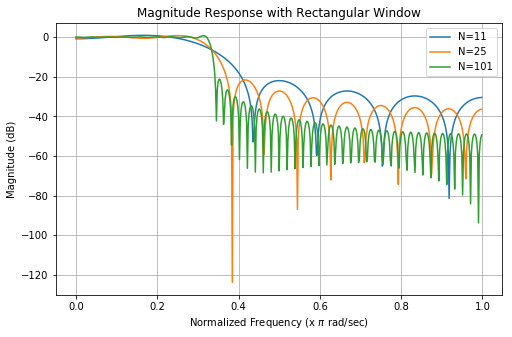

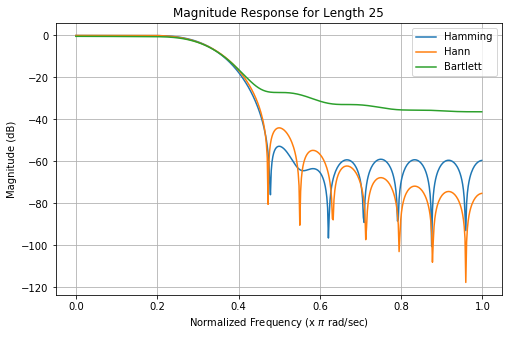

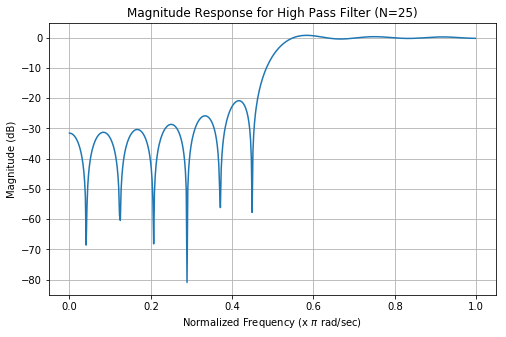

In [2]:
#Fill in this function for part 1.a:
def windowed_lpf(omega_c,N,window=np.ones):
    #create ideal impulse response in time domain before windowing
    M = (N-1) // 2
#     h = [np.sin(omega_c*(n-M))/(np.pi*(n-M)) for n in range(N)]
#     h[M] = omega_c/np.pi
    h = [(omega_c/np.pi)*np.sinc(omega_c*(n-M)/np.pi) for n in range(N)]

    #apply window function 
    lpf = h*window(N)
    return lpf

#Code for part 1.b:
lpf1 = windowed_lpf(np.pi/3, 11)
lpf2 = windowed_lpf(np.pi/3, 25)
lpf3 = windowed_lpf(np.pi/3, 101)

w1,h1 = signal.freqz(lpf1)
w2,h2 = signal.freqz(lpf2)
w3,h3 = signal.freqz(lpf3)

plt.figure(figsize=(8,5))
plt.title('Magnitude Response with Rectangular Window')
plt.plot(w1/np.pi, sig2db(np.absolute(h1)), label='N=11')
plt.plot(w2/np.pi, sig2db(np.absolute(h2)), label='N=25')
plt.plot(w3/np.pi, sig2db(np.absolute(h3)), label='N=101')
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()

#Code for part 1.c:
lpf1 = windowed_lpf(np.pi/3, 25, signal.hamming)
lpf2 = windowed_lpf(np.pi/3, 25, signal.hann)
lpf3 = windowed_lpf(np.pi/3, 25, signal.bartlett)

w1,h1 = signal.freqz(lpf1)
w2,h2 = signal.freqz(lpf2)
w3,h3 = signal.freqz(lpf3)

plt.figure(figsize=(8,5))
plt.title('Magnitude Response for Length 25')
plt.plot(w1/np.pi, sig2db(np.absolute(h1)), label='Hamming')
plt.plot(w2/np.pi, sig2db(np.absolute(h2)), label='Hann')
plt.plot(w3/np.pi, sig2db(np.absolute(h3)), label='Bartlett')
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()

#Code for 1.d:
hpf = windowed_lpf(np.pi/2, 25)

# modulate with cos(n*PI) = +1,-1,+1,-1,...
nhalf = len(hpf)//2
for i in range(1, nhalf+1, 2):
    hpf[nhalf-i] = -hpf[nhalf-i]
    hpf[nhalf+i] = -hpf[nhalf+i]

plt.figure(figsize=(8,5))
w, h = signal.freqz(hpf)
plt.title('Magnitude Response for High Pass Filter (N=25)')
plt.plot(w/np.pi, sig2db(np.absolute(h)))
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude (dB)')
plt.grid()


Comments for 1.b:

The three filters are clearly related, though you can see significant differences in the transition band width and the stop band attenuation for different filter lengths.  The longer filters have significantly reduced transition bands, with the N=101 filter being almost vertical at about pi/3.  In the stop band, each filter has a secondary lobe height of -20dB, though the longer filters fall off much faster for subsequent lobes than the shorter filters.  The N=101 filter reaches -40dB by about pi/2 , while the N=11 filter just barely breaks -30dB by pi.  The passband ripple is most noticable in the N=101 filter, but is also present in about the same magnitude in the other two filters.

Comments for 1.c:

The Bartlett window seems to be the worst of the bunch, as it is basically an envelope of the rectangular window.  Each of the three new windows have the same transition band width, which is about twice that of the rectangular window, and the pass band ripple is nearly gone for the new windows.  The stop band attenuation is where the real differences lie, with the Hamming window having the smallest secondary lobe and the Hann window having smaller higher frequency lobes.  Even though the Hamming window is higher than the Hann window at higher frequencies, it is still at -60dB, which is 1000x attenuation, and it maintains that for almost the entire stop band.  This is opposed to the -45dB (~100x) attenuation from the Hann window near the cutoff frequency.



## Parks-McClellan

Another method for linear phase filter design is Parks-McClellan via the Remez exchange algorithm. We will not consider the exact math behind this algorithm; still, the main takeaway for Parks-McClellan is that it solves an optimization problem to minimize error between the practical and ideal filter responses.

Let's consider how we can use Parks-McClellan to design linear phase filters. The function of interest we will use is $\textrm{signal.remez()}$. There are many options we may pass to this function; however, we will focus on specifying the filter length, frequency bands, and desired levels of gain. Let's look at a couple examples:

In [3]:
"""
signal.remez(numtaps,bands,desired,fs=2)
Inputs:
numtaps - Filter length.
bands - List of band edges in normalized frequency [0,1]
        where 1 correponds to pi.
desired - List of desired gains for each frequency bands.
          Must be half the length of the bands list.
fs=2 - This argument guarantees the input frequencies are on the normalized
       [0,1] frequency axis.
Output:
out - Array of computed FIR filter coefficients.
"""

N = 50
a = [1,0]
#Low-pass Filter
#0-0.5 is passband, 0.7-1 is the stopband, transition band is then 0.5-0.7
lpf_bands = [0,0.5,0.7,1]
lpf_desired = [1,0] #gain of one for passband, gain of zero for stopband
lpf = signal.remez(N,lpf_bands,lpf_desired,fs=2)
w,H_lpf = signal.freqz(lpf,a)
#Band-pass Filter
#0-0.2 is first stopband, 0.3-0.6 is passband, 0.7-1 is second stopband
bpf_bands = [0,0.2,0.3,0.6,0.7,1]
bpf_desired = [0,1,0]
bpf = signal.remez(N,bpf_bands,bpf_desired,fs=2)
w,H_bpf = signal.freqz(bpf,a)

#Compare magnitude responses
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('Low-pass Filter')
plt.plot(w,sig2db(abs(H_lpf)))
plt.subplot(122)
plt.title('Band-pass Filter')
plt.plot(w,sig2db(abs(H_bpf)))

TypeError: remez() got an unexpected keyword argument 'fs'

## Exercise 2: Parks-McClellan Design

In this exercise, we will practice creating linear phase FIR filters using the Parks-McClellan method and explore the inherent design tradeoffs at play. For this exercise, you may assume all passbands have a desired gain of one and all stopbands have a desired gain of zero.

a. Create a high-pass filter with stopband 0 to 0.5 and passband 0.7 to 1 for lengths $N=11, 25,$ and $101$. Plot the magnitude response of the filters on a dB scale. Comment on the differences between each filter. What improves as we increase the filter length?

b. Now let's consider the effect of the transition bandwidth on the resulting frequency response. In part 2.(a), we had a transition bandwidth of 0.2 (0.7-0.5). Try varying this transition bandwidth by changing how close the stopband comes to the passband. Try stopband edge values between 0.4 and 0.65. Provide a magnitude response plot for a stopband edge other than the 0.5 from part 2.(a). Comment on the design tradeoff we see by varying the stopband edge. In other words, what do we gain or lose by increasing or decreasing the transition bandwidth?

In [4]:
#Code for 2.a:
a = [1,0]

hpf_bands = [0,0.5,0.7,1]
hpf_desired = [0,1]
hpf_11 = signal.remez(11,hpf_bands,hpf_desired,fs=2)
hpf_25 = signal.remez(25,hpf_bands,hpf_desired,fs=2)
hpf_101 = signal.remez(101,hpf_bands,hpf_desired,fs=2)

w_11,H_hpf_11 = signal.freqz(hpf_11,a)
w_25,H_hpf_25 = signal.freqz(hpf_25,a)
w_101,H_hpf_101 = signal.freqz(hpf_101,a)

plt.figure(figsize=(15,6))
plt.title('High-Pass Filters of Various Length')
plt.plot(w_11/np.pi, sig2db(abs(H_hpf_11)), label='N=11')
plt.plot(w_25/np.pi, sig2db(abs(H_hpf_25)), label='N=25')
plt.plot(w_101/np.pi, sig2db(abs(H_hpf_101)), label='N=101')
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude Response (dB)')
plt.grid()
plt.legend()

#Code for 2.b:


plt.figure(figsize=(15,6))
plt.title('Effect of Varying Transition Bandwidth')
for i in [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]:
    hpf_bands = [0,i,0.7,1]
    hpf_desired = [0,1]
    hpf = signal.remez(101,hpf_bands,hpf_desired,fs=2)
    w,H_hpf = signal.freqz(hpf,a)
    
    plt.plot(w/np.pi, sig2db(abs(H_hpf)), label=('$\omega_c$ = ' + str(i)))

plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude Response (dB)')
plt.grid()
plt.legend()

TypeError: remez() got an unexpected keyword argument 'fs'

Comments for Part 2.a:

The longer filters have more side lobes and shorter transition bands. The side lobes on longer filters are also considerably lower than the shorter filters.


Comments for Part 2.b:

The various filters with different stopband cutoffs each have varying levels of stopband attenuation.  As the stopband gets narrower, you pay by having larger side lobes.  Interestingly, the filter with ωc=.4  is not flat in the stopband like the others, but instead tapers off towards lower frequencies.

## Exercise 3: Audio De-Noising

Now that we have some experience using Parks-McClellan, lets apply it to clean up a noisy audio signal! Listen to the following noisy audio clip.

In [5]:
fs, audio = wavfile.read('sound1.wav')
Audio(data = audio, rate = fs)

a. Plot the magnitude of the FFT of the audio signal using $\textrm{np.fft.rfft()}$ (do not indicate the number of points since the signal is already plenty long!). Where do you think the noise is present in the spectrum with respect to digital frequencies?

b. Create a length 25 filter using Parks-McLellan method via $\textrm{signal.remez()}$ that will remove this noise from the audio signal. Plot the magnitude response of your filter on a dB scale. Briefly justify your choice of design, e.g. band edges, filter type.

c. Apply your filter to the noisy audio using any method you think appropriate in either the frequency or time domain. Plot the magnitude of the FFT of the filtered audio signal. Listen to the resulting audio in the following code cell to verify your filter works!

TypeError: remez() got an unexpected keyword argument 'fs'

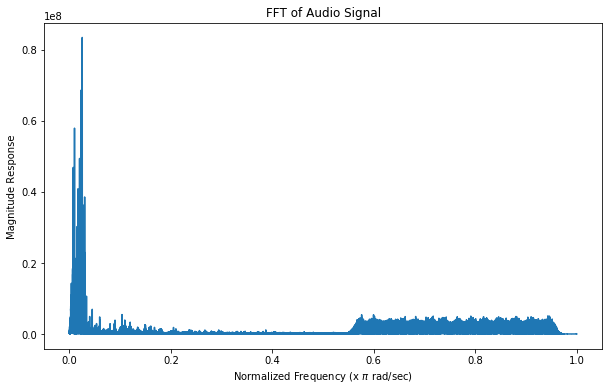

In [6]:
#Code for part 3.a:
fft = np.fft.rfft(audio)
w = np.linspace(0, np.pi, len(fft))

plt.figure(figsize=(10,6))
plt.title('FFT of Audio Signal')
plt.plot(w/np.pi, np.absolute(fft))
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude Response')

#Code for part 3.b:
N = 25
a = [1,0]
lpf_bands = [0,0.3,0.5,1]
lpf_desired = [1,0]
lpf = signal.remez(25,lpf_bands,lpf_desired,fs=2)

w,H_lpf = signal.freqz(lpf,a)

plt.figure(figsize=(10,5))
plt.title('Magnitude Response of Noise Filter')
plt.plot(w/np.pi, sig2db(np.absolute(H_lpf)))
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude Response (dB)')
plt.grid()

#Code for part 3.c:

audio_filtered = signal.filtfilt(lpf, 1, audio)
fft_filtered = np.fft.rfft(audio_filtered)
w = np.linspace(0, np.pi, len(fft_filtered))

plt.figure(figsize=(10,5))
plt.title('FFT of Filtered Audio')
plt.plot(w/np.pi, np.absolute(fft_filtered))
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude Response')
plt.grid()

In [7]:
#Verify your filtered audio here!
Audio(data = audio_filtered, rate = fs)

NameError: name 'audio_filtered' is not defined

Comments for 3.a:

The noise looks to be from about 0.55pi to 0.95pi.

Comments for 3.b:

I chose a low-pass filter to keep the audio signal in the low frequencies and cut out the high frequency noise.  I chose a stopband cutoff of 0.5pi and a transition bandwidth of 0.2pi, which gives a very flat passband and sufficiently small stopband ripples.

Thus far we have simply assumed that linear phase is desirable. In this exercise, we will show the impact of linear phase by considering FIR and IIR image filtering.

## Exercise 4: Why Linear Phase?

Your best friend is going to Hollywood to make it big as an actor! There's only one problem: their headshot photo is full of noise! 

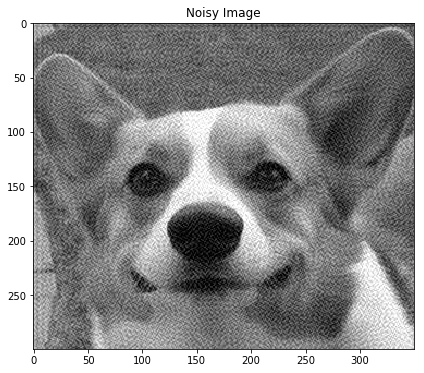

In [8]:
noisy = imread('noisy-photo.jpg')
plt.figure(figsize=(10,6))
plt.imshow(noisy,'gray')
plt.title('Noisy Image')

You decide to help your friend by trying to smooth out some of the noise, but you are not sure if an FIR or IIR filter will work better. Let's compare the results for each kind of filter.

a. We have provided the code that generates a suitable IIR filter for this exercise. The numerator and denominator coefficients for this filter are stored in the variables ``iir_num`` and ``iir_den``, respectively, and the frequency response can be found in ``H_iir``. Create an FIR filter with similar magnitude response using $\textrm{signal.remez()}$. The filter should be bandstop with passbands from 0-0.1 and 0.6-1 , stopband from 0.2-0.5, and length 25. Plot the magnitude response on a dB scale for both the IIR and FIR filters on the same plot and the phase response for each filter on side-by-side subplots. You should obtain very similar magnitude responses for the two filters. Comment on the differences between the two phase responses. Do they both have generalized linear phase?

b. Apply the FIR filter to the noisy image along the rows then along the columns using $\textrm{signal.convolve()}$ in the ``same`` mode. Refer back to Lab 2 where you performed a similar task if you are unsure what to do! Plot the resulting image in grayscale.

c. Apply the IIR filter to the noisy image along the rows then along the columns using $\textrm{signal.lfilter()}$. Plot the resulting image in grayscale.

Note: For parts 4.(b) and 4.(c) do not forget to use your row-filtered image when performing filtering along the columns!

d. Compare the FIR and IIR filtered images. You should see a clear difference especially in places like your friend's nose and other facial features. What is the main cause of these differences?

In [9]:
#Provided code:
shape = noisy.shape
n_rows,n_cols = shape[0],shape[1]

iir_num,iir_den = signal.iirdesign(ws=[0.2,0.5],wp=[0.15,0.55],gpass=1,gstop=25)
w,H_iir = signal.freqz(iir_num,iir_den)

#Code for part 4.a:
fir_bands = [0,0.1,0.2,0.5,0.6,1]
fir_desired = [1,0,1]
fir = signal.remez(25, fir_bands, fir_desired, fs=2)

a = [1,0]
w,H_fir = signal.freqz(fir,a)

plt.figure(figsize=(16,5))
plt.title('Magnitude Response of Bandstop Filters')
plt.plot(w/np.pi, sig2db(np.absolute(H_fir)), label='FIR')
plt.plot(w/np.pi, sig2db(np.absolute(H_iir)), label='IIR')
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude Response (dB)')
plt.grid()
plt.legend()

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.title('Phase Response of FIR Filter')
plt.plot(w/np.pi, np.angle(H_fir))
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude Response (dB)')
plt.grid()

plt.subplot(122)
plt.title('Phase Response of IIR Filter')
plt.plot(w/np.pi, np.angle(H_iir))
plt.xlabel('Normalized Frequency (x $\pi$ rad/sec)')
plt.ylabel('Magnitude Response (dB)')
plt.grid()

#Code for part 4.b:
image_fir = np.zeros(noisy.shape)
for i in range(noisy.shape[0]):
    image_fir[i,:] = signal.convolve(noisy[i,:], fir, 'same')
for i in range(noisy.shape[1]):
    image_fir[:,i] = signal.convolve(image_fir[:,i], fir, 'same')

plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title('FIR Filtered Image')
plt.imshow(image_fir, 'gray')

#Code for part 4.c:
image_iir = np.zeros(noisy.shape)
for i in range(noisy.shape[0]):
    image_iir[i,:] = signal.lfilter(iir_num, iir_den, noisy[i,:])
for i in range(noisy.shape[1]):
    image_iir[:,i] = signal.lfilter(iir_num, iir_den, image_iir[:,i])

plt.subplot(122)
plt.title('IIR Filtered Image')
plt.imshow(image_iir, 'gray')

TypeError: remez() got an unexpected keyword argument 'fs'

Comments for part 4.a:

The phase response for the FIR filter is GLP but the IIR filter is certainly not.  The FIR phase response only contains jumps of 2pi in the passbands and is otherwise linear. The IIR phase in the passbands is clearly not linear, and it contains a jump of less than 2pi just before 0.2pi.

Comments for part 4.d:

Both filters produce a blurred version of the image, but the FIR does a better job of preserving the facial features due to the linear phase of the FIR opposed to the IIR filter.  The time-varying (position-varying) phase of the IIR creates a ripple that distorts the features of the photo.


## An Introduction to Adaptive Filtering and LMS Filtering

Thus far, we have worked with carefully designed LSI filters. We took some knowledge of the signal in the time and/or frequency domain and devised an approriate filter. Consider the scenarios where we have uncertainty or randmoness in our signal, design constraints that are too difficult to work with by hand, or simply lack necessary information about the system. Perhaps as we go through our signal we would find one filter is best in the first third, another in the middle, and a third filter is optimal at the end of the signal. Designing or tuning three filters by hand and specifically deploying them on segments of the signal is too much work! What if we could learn an optimal filter "on-the-fly" or "on-line"?

This question is the central goal behind adaptive filtering. Adaptive filtering is found in many applications including noise-canceling headphones and echo/reverberation cancellation. When creating an adaptive filter, we would like our filter to adjust its own coefficients as it processes the signal. How does it do this? By observing the errors in the output it produces and altering its coefficients to mitigate these errors. This way, we do not need to precisely design our filter; instead, we just give it the mechanism for updating itself! Now, let's take a look at the math and underlying theory for one type of adaptive filtering: Least Mean Squares (LMS) filtering.

The goal of LMS filtering is to use previous memory of input signal values to predict the desired output value. As such, when doing LMS filtering, we typically have a reference output signal that we are trying to emulate. Consider the context where we know the ideal (reference) output, but we do not know the filter that will turn our input into this ideal output. Therefore, we would like to tune our filter's coefficients such that our filter applied to the memory of input values will produce a strong prediction of the ideal output at each sample. Let $x[n]$ be the input to our LSI system, $w$ be our adaptive filter of length $L$, $y[n]$ be our filter's output, and $d[n]$ be the reference output. This scenario, also known as single step prediction, is depicted by the below figure.

<img src="adaptive-filter.png">

We may determine our output $y[n]$ by computing $y[n] = \sum_{k=0}^{L-1}w[k]x[n-k]$. In this figure, $e[n] = d[n]-y[n]$ represents the error signal from our output predictions. We would like to use this error signal to inform our filter and update its values. How can we perform these updates? Through an algorithm known as gradient descent. Gradient descent is a tremendously popular iterative algorithm used in several fields including deep learning, optimization, and many more. Recall from calculus that we can find a minimum or maximum of a function by setting its derivative to zero. Gradient descent extends this intuition to higher-dimensional functions where instead we would like the gradient to be zero. We may formulate the gradient descent update step as follows:

$$
w^{(n+1)} = w^{(n)} - \alpha\nabla C(w^{(n)}).
$$

Here, we take the gradient of a cost function $C$ that we would like to minimize with respect to our adaptive filter $w$. Again, take note that we apply gradient descent at each sample index to update our filter before processing the next sample in our signal. The superscript $n$ denotes the iteration number of our gradient descent algorithm. The gradient descent formula updates our filter by having it step in the direction of the $\textit{negative gradient}$ at each iteration. This way, we expect to decrease our gradient until (hopefully) it goes to zero and we minimize our cost. Imagine gradient descent like you are trying to walk down a hill. At each step you take, you will choose to step in the steepest direction of descent until you reach the bottom (our optimal filter). Above, the parameter $\alpha$ is referred to as the learning rate. The learning rate determines how large our gradient updates are. We must take great care in tuning $\alpha$ since if $\alpha$ is too large, we may over-update at each step (imagine jumping from one hilltop to another hilltop) and never converge and if $\alpha$ is too small, we may converge too slowly (imagine taking a "baby step" to go down a large hill). We will examine this further in Exercise 5.

Now, let's make the update to our LMS filter more concrete. What we need is a cost function that is a function of our filter coefficients. We can find this by considering our filter's squared prediction errors. Using the same notation from before,

$$
C(w^{(n)}) = \frac{1}{2}e^2[n].
$$

Taking the gradient $\nabla_wC(w^{(n)})$ and applying the chain rule of differentiation:

$$
\nabla_wC(w^{(n)}) = e[n]\nabla_w(e[n])
$$

$$
=e[n]\left[\frac{\partial e[n]}{\partial w^{(n)}[0]},\frac{\partial e[n]}{\partial w^{(n)}[1]},\ldots,\frac{\partial e[n]}{\partial w^{(n)}[L-1]}\right]. 
$$

Recalling that $e[n] = d[n]-y[n] = d[n] - \sum_{k=0}^{L-1}w^{(n)}[k]x[n-k]$,

$$
= e[n]\left[-x[n],-x[n-1],\ldots,-x[n-(L-1)]\right]
$$

$$
\nabla C(w^{(n)}) = -e[n]X,
$$

where $X = [x[n],x[n-1],\ldots,x[n-(L-1)]]$ is our "memory signal" for the $L$ most recent signal values and $e[n]$ is still our scalar prediction error at step/index $n$. Putting this all together, we have our gradient update for a single step prediction LMS filter:

$$
w^{(n+1)} = w^{(n)} -\alpha(-e[n]X) = w^{(n)} +\alpha e[n]X.
$$

How simple, how elegant! Now, let's try it out in practice!

## Exercise 5: Don't Design, Learn!

Your best friend (same one from Exercise 4: couldn't make it as an actor) has been bragging to you that they have created the coolest LSI filter ever. Naturally, you are jealous and would like to know what the filter coefficients are, but your friend refuses to tell! All they are willing to do is provide you with a Python function that produces input-output pairs passed through their filter to show off its performance. Can LMS filtering help you uncover your friend's filter? Let's find out!

(To make this exercise most concrete, the code and your friend's filter will be shown to you; however, the usefulness of LMS filtering should still be apparent.)

a. We have provided the function to generate the input-output pair from your friend's filter and most of the LMS filtering function. For this part, fill in the one missing line (given by the ???) and test the LMS filter algorithm with $\alpha = 10^{-4}$ and initial filter coefficients of all zeros. Plot the filter errors (Euclidean distance between the actual filter and the LMS filter at each iteration) and print the final estimate of your friend's filter.

b. Test the LMS filter algorithm for learning rates $\alpha = 10^{-2}$ and $\alpha = 10^{-6}$ with the same zero initial filter coefficients. On separate subplots, plot the filter errors for each case and briefly comment on what is happening. Refer to the background discussion above regarding the learning rate if you are unclear.

c. Test the LMS filter algorithm with different initial filter coefficients. With $\alpha = 10^{-4}$, try initializing the filter coefficients with all ones and with random values using $\textrm{randn()}$. Plot the filter errors for each case and briefly comment on the results. How do they compare to zero initial coefficients? Does the LMS filter still work?

Suppose your friend changes the input-output function such that the output now has some random noise added. Can the LMS filter still decode your friend's filter?

d. Test the LMS filter algorithm using the noisy input-output signal pair. Let $\alpha=10^{-4}$ and the initial filter coefficients be all zeros. Plot the filter errors and print the final estimate of your friend's filter.

Final Sample Estimates (alpha=10^(-4)):       [ 1.0000007   1.99996399  2.99987837  3.99986416  4.99986532]
Final Noisy Sample Estimates (alpha=10^(-4)): [ 1.03583008  2.03435891  2.99319047  4.00960958  4.9685338 ]


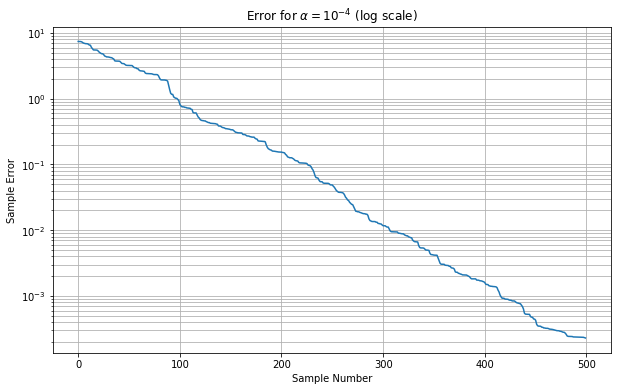

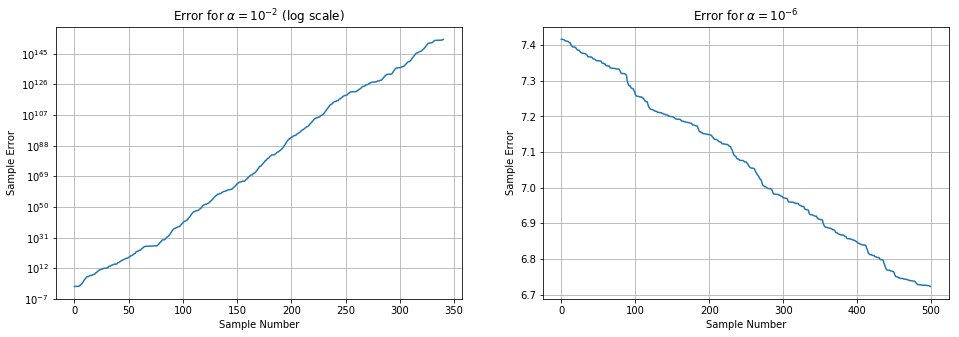

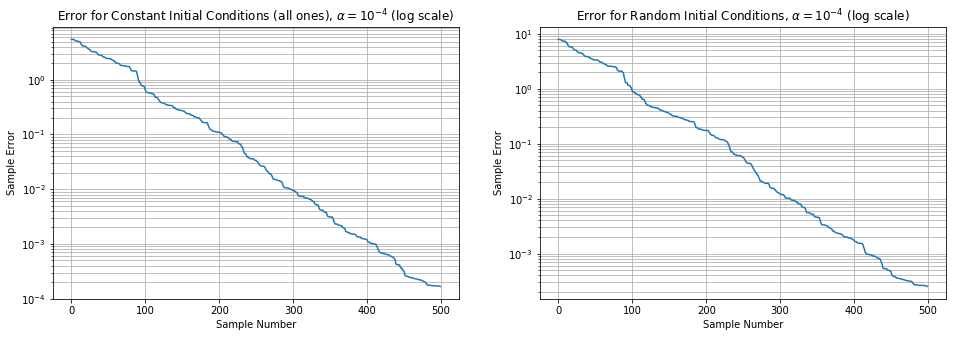

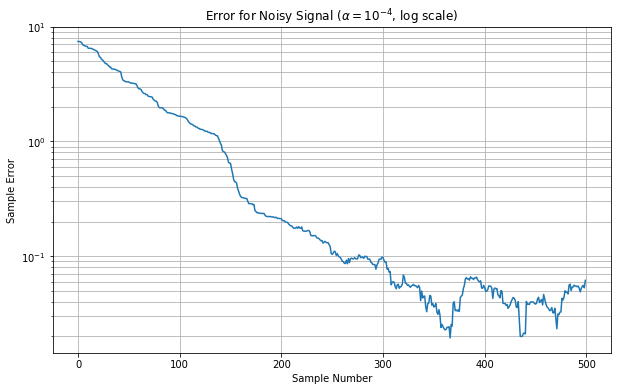

In [10]:
#Provided functions
def generate_xy(h,N):
    x = np.random.randint(low=-25,high=26,size = N)
    y = signal.convolve(h,x)
    return x,y

def generate_xy_noisy(h,N):
    x = np.random.randint(low=-25,high=26,size = N)
    y = signal.convolve(h,x).astype(np.float64)
    y += randn(len(y))*3 #Gaussian noise with standard deviation 3
    return x,y

#Fill in missing line for Part 5.a:
"""
lms(x,y,h,alpha,w_init):
Inputs:
x - input signal
y - output signal
h - your friend's filter (to check how well we learn it)
alpha - learning rate
w_init - initial filter coefficients

Outputs:
w_err - L2 errors (Euclidean distance) of LMS filter against your friend's filter
w - final estimate of your friend's filter
"""
def lms(x,y,h,alpha,w_init):
    N,L = len(x),len(h)
    w = w_init #adaptive filter
    w_err = np.zeros(N) #array to track filter coefficient errors
    X = np.zeros(L) #memory signal
    for n in range(N):
        X[0] = x[n] #update most recent (current) value
        d_n = y[n] #step to predict
        y_predict = np.dot(w,X) #predict y by w^Tx
        w_err[n] = np.linalg.norm(h - w) #error in filter coefficients
        e_n = d_n - y_predict #prediction error
        w = w + alpha*e_n*X  #filter update by gradient descent
        X = np.roll(X,1) #circularly shift right by one
    return w_err,w

h = np.array([1,2,3,4,5])
N = 500
x,y = generate_xy(h,N)

#Fill in missing line for Part 5.a:
"""
lms(x,y,h,alpha,w_init):
Inputs:
x - input signal
y - output signal
h - your friend's filter (to check how well we learn it)
alpha - learning rate
w_init - initial filter coefficients

Outputs:
w_err - L2 errors (Euclidean distance) of LMS filter against your friend's filter
w - final estimate of your friend's filter
"""
def lms(x,y,h,alpha,w_init):
    N,L = len(x),len(h)
    w = w_init #adaptive filter
    w_err = np.zeros(N) #array to track filter coefficient errors
    X = np.zeros(L) #memory signal
    for n in range(N):
        X[0] = x[n] #update most recent (current) value
        d_n = y[n] #step to predict
        y_predict = np.dot(w,X) #predict y by w^Tx
        w_err[n] = np.linalg.norm(h - w) #error in filter coefficients
        e_n = d_n - y_predict #prediction error
        w = w + alpha*e_n*X #filter update by gradient descent
        X = np.roll(X,1) #circularly shift right by one
    return w_err,w

h = [1,2,3,4,5]
N = 500
x,y = generate_xy(h,N)

#Code for part 5.a:
w_err,w = lms(x, y, h, 10**(-4), np.zeros(len(h)))
plt.figure(figsize=(10,6))
plt.semilogy(range(len(w_err)), w_err)
plt.title(r'Error for $\alpha=10^{-4}$ (log scale)')
plt.xlabel('Sample Number')
plt.ylabel('Sample Error')
plt.grid(which='both')

print(r'Final Sample Estimates (alpha=10^(-4)):      ', w)

#Code for part 5.b:
w_err2,w = lms(x, y, h, 10**(-2), np.zeros(len(h)))
w_err6,w = lms(x, y, h, 10**(-6), np.zeros(len(h)))

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.semilogy(range(len(w_err2)), w_err2)
plt.title(r'Error for $\alpha=10^{-2}$ (log scale)')
plt.xlabel('Sample Number')
plt.ylabel('Sample Error')
plt.grid(which='both')

plt.subplot(122)
plt.plot(range(len(w_err6)), w_err6)
plt.title(r'Error for $\alpha=10^{-6}$')
plt.xlabel('Sample Number')
plt.ylabel('Sample Error')
plt.grid()

#Code for part 5.c:
w_err_ones,w = lms(x, y, h, 10**(-4), np.ones(len(h)))
w_err_rand,w = lms(x, y, h, 10**(-4), randn(len(h)))

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.semilogy(range(len(w_err_ones)), w_err_ones)
plt.title(r'Error for Constant Initial Conditions (all ones), $\alpha=10^{-4}$ (log scale)')
plt.xlabel('Sample Number')
plt.ylabel('Sample Error')
plt.grid(which='both')

plt.subplot(122)
plt.semilogy(range(len(w_err_rand)), w_err_rand)
plt.title(r'Error for Random Initial Conditions, $\alpha=10^{-4}$ (log scale)')
plt.xlabel('Sample Number')
plt.ylabel('Sample Error')
plt.grid(which='both')

#Code for part 5.d:
x_noisy,y_noisy = generate_xy_noisy(h,N)

w_err_noisy,w = lms(x_noisy, y_noisy, h, 10**(-4), np.zeros(len(h)))
plt.figure(figsize=(10,6))
plt.semilogy(range(len(w_err_noisy)), w_err_noisy)
plt.title(r'Error for Noisy Signal ($\alpha=10^{-4}$, log scale)')
plt.xlabel('Sample Number')
plt.ylabel('Sample Error')
plt.grid(which='both')

print(r'Final Noisy Sample Estimates (alpha=10^(-4)):', w)


## Submission Instructions

Please rename this notebook to "netid_Lab6" and submit a zip file including all the supplied files for this lab to Compass. Please also name your zip file submission "netid_Lab6".